# Cats and Dogs

Este notebook implementa um experimento de **transferência de conhecimento** (*"transfer learning"*)

## Código de suporte

### Módulos utilizados

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import time
import glob
import sys
import copy
import pickle
import numpy as np
import numpy.random as nr
from PIL import Image
import scipy.ndimage

from collections import OrderedDict

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models

# from course libs
sys.path.append('../lib')
from pytorch_utils import DeepNetTrainer

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)


GPU available: True


## Dataset

In [2]:
class PetsDataset(Dataset):
    
    def __init__(self, data_dir, transforms=None, is_validation=False, is_test=False,
                 use_only=1.0, validation_split=0.1, random_seed=20170929):        
        self.transforms = transforms
        if is_test:
            self.classes = ['unknown']
            self.pets = []
            self.is_dog = []
            pet_count = len(glob.glob(data_dir + '/*.jpg'))
            for index in range(1, pet_count + 1):
                path = os.path.join(data_dir, '{}.jpg'.format(index))
                self.pets.append(path)
                self.is_dog.append(0)
        else:
            nr.seed(random_seed)
            pets = nr.permutation(glob.glob(data_dir + '/*.jpg'))
            length = pets.shape[0]
            only = int(use_only * length)
            pets = pets[:only]
            length = pets.shape[0]
            vlen = int(validation_split * length)
            if is_validation:
                self.pets = pets[:vlen]
            else:
                self.pets = pets[vlen:]
            self.is_dog = np.array([os.path.basename(fn).startswith('dog') for fn in self.pets], np.int)
            self.classes = ['cat', 'dog']

    def __len__(self):
        return len(self.pets)
    
    def __getitem__(self, index):
        path = self.pets[index]
        label = self.is_dog[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')                
        if self.transforms is not None:
            image = self.transforms(image)
        return image, label
    

In [3]:
data_path = '/data/datasets/CatsDogs_kaggle/train'
test_path = '/data/datasets/CatsDogs_kaggle/test1'
batch_size = 50
img_width, img_height = 224, 224

def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

dsets = {
    'train': PetsDataset(data_path, transforms=data_transforms['train'], validation_split=0.2),
    'valid': PetsDataset(data_path, transforms=data_transforms['valid'], is_validation=True, validation_split=0.2),
    'test':  PetsDataset(test_path, transforms=data_transforms['valid'], is_test=True),
}

dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True,  pin_memory=True),
    'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False, pin_memory=True),
    'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False, pin_memory=True),
}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = dsets['train'].classes
dset_classes, dset_sizes

(['cat', 'dog'], {'test': 12500, 'train': 20000, 'valid': 5000})

### Alguns exemplos

torch.Size([3, 224, 224]) torch.Size([50])


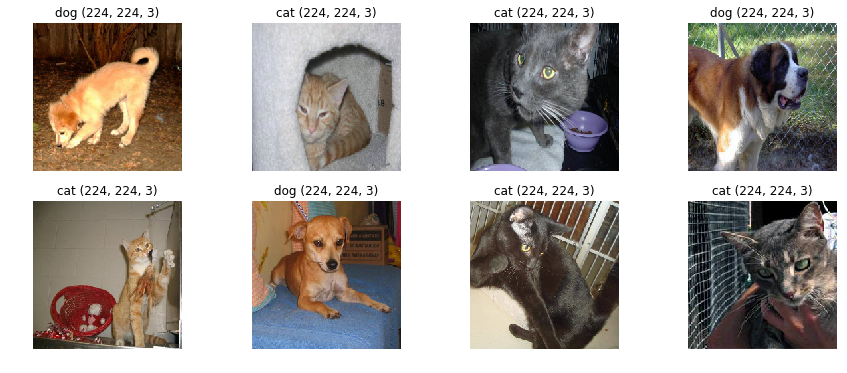

In [4]:
# Get a batch of training data
inputs, cls = next(iter(dset_loaders['train']))

print(inputs[8].shape, cls.shape)

fig = plt.figure(figsize=(15,6))
for i, j in enumerate(range(4)):
    fig.add_subplot(2,4, i+1)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')
    
for i, j in enumerate(range(4, 8)):
    fig.add_subplot(2,4, i+5)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')


## Métricas

In [5]:
def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return torch.sum(preds == labels.data) / labels.size(0)

## Modelo

In [6]:
class MyResNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)    
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        n_feat = self.resnet.fc.in_features
        fc_old = self.resnet.fc.state_dict()            
        fc_new = dict(weight=fc_old['weight'][(284, 208), :], bias=fc_old['bias'][(284, 208),])

        self.resnet.fc = nn.Linear(n_feat, 2)
        self.resnet.fc.load_state_dict(fc_new)

    def forward(self, input_):
        return self.resnet.forward(input_)


## Treinamento

In [7]:
model = MyResNet()
if use_gpu:
    model = model.cuda()

if 1:
    for param in model.resnet.layer4.parameters():
        param.requires_grad = True
    optimizer = optim.Adam([{'params': model.resnet.layer4.parameters(), 'lr': 1e-6}, 
                            {'params': model.resnet.fc.parameters(),     'lr': 1e-5}])
    scheduler = StepLR(optimizer, step_size=10, gamma=0.75)
    
else:
    optimizer =  optim.Adam(model.resnet.fc.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

loss_function = nn.CrossEntropyLoss()
metrics = dict(acc=compute_accuracy)

# model

In [8]:
trainIt = True

training_parameters = {
    'file_basename': '../../../models/cats_dogs_resnet34_01', 
    'model':         model, 
    'criterion':     loss_function, 
    'metrics':       metrics, 
    'optimizer':     optimizer, 
    'lr_scheduler':  scheduler, 
    'reset':         False,
}

trainer = DeepNetTrainer(**training_parameters)

if trainIt:
    trainer.fit(100, dset_loaders['train'], dset_loaders['valid'])

else:
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))

Model loaded from ../../models/cats_dogs_resnet34_01.model
Starting training for 100 epochs

 36:   0.0s   T: 0.01380 0.99580   V: 0.03415 0.98920 best
 37: 293.1s   T: 0.01164 0.99675   V: 0.03497 0.98880 
 38: 286.5s   T: 0.01151 0.99700   V: 0.03452 0.98840 
Interrupted!!

Model from epoch 36 saved as "../../models/cats_dogs_resnet34_01.*", loss = 0.03415


In [9]:
trainer = DeepNetTrainer(**training_parameters)

metrics = trainer.evaluate(dset_loaders['train'])
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate(dset_loaders['valid'])
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

Model loaded from ../../models/cats_dogs_resnet34_01.model
evaluate: 399 ok
Model training set accuracy after training: 0.99950

evaluate: 99 ok
Model validation set accuracy after training: 0.98920


### Evolução do custo e acurácia

  Last training loss: 0.01380, accuracy: 0.99580
Last validation loss: 0.03415, accuracy: 0.98920


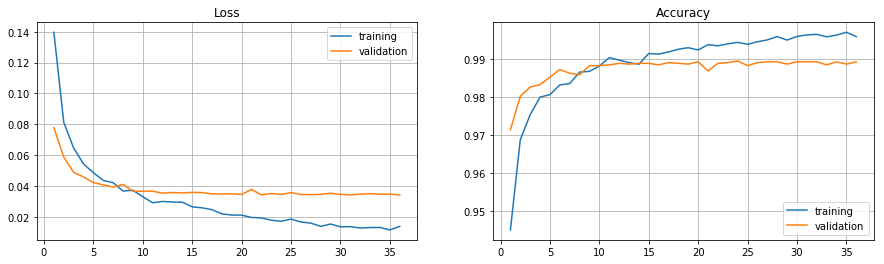

In [10]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(1, 2, 1)
plt.plot([None] + trainer.metrics['train']['losses'], label='training')
plt.plot([None] + trainer.metrics['valid']['losses'], label='validation')
plt.grid()
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot([None] + trainer.metrics['train']['acc'], label='training')
plt.plot([None] + trainer.metrics['valid']['acc'], label='validation')
plt.grid()
plt.title('Accuracy')
plt.legend(loc='lower right')

print('  Last training loss: {:.5f}, accuracy: {:.5f}'
      .format(trainer.metrics['train']['losses'][-1], trainer.metrics['train']['acc'][-1]))
print('Last validation loss: {:.5f}, accuracy: {:.5f}'
      .format(trainer.metrics['valid']['losses'][-1], trainer.metrics['valid']['acc'][-1]))

## Avaliação

### Funções auxiliares

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = denormalize(inp.numpy())
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_mismatches(trainer, dset=dset_loaders['valid'], num_images=12):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(dset):
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size(0)):
            if preds[j] == labels[j]:
                continue
            images_so_far += 1
            ax = plt.subplot(num_images//4, 4, images_so_far)
            ax.axis('off')
            ax.set_title('pred/lab: {} / {}'.format(dset_classes[preds[j]], dset_classes[labels[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

def visualize_mismatch_probas(trainer, dloader=dset_loaders['valid'], num_images=16):
    from torch.nn.functional import softmax

    images = []
    labels = []
    logits = []
    preds = trainer.predict(dloader).numpy()
    k = 0
    for i, data in enumerate(dloader):
        binp, blab = data
        bs = binp.size(0)
        
        bpreds = preds[k:k+bs]
        blabel = np.argmax(bpreds, 1)
        k += bs
        
        errs = np.not_equal(blabel, blab.numpy())        
        images.append(binp.numpy()[errs])
        labels.append(blab.numpy()[errs])
        logits.append(bpreds[errs])
                
    logits = np.vstack(logits)
    images = np.vstack(images)
    labels = np.hstack(labels)
    
    print('mistakes: {} / {}'.format(logits.shape[0], preds.shape[0]))
    
    probas = softmax(torch.from_numpy(logits)).data.numpy()
    sorted_indexes = np.argsort(probas[:, 1])
    
    fig = plt.figure(figsize=(15, 15))
    images_so_far = 0
    for indexes in [sorted_indexes[:8], sorted_indexes[-8:]]:
        for i, (image, label, proba) in enumerate(zip(images[indexes], 
                                                      labels[indexes], 
                                                      probas[indexes])):
            images_so_far += 1
            ax = plt.subplot(4, 4, images_so_far)
            ax.axis('off')
            ax.set_title('[{}] {:.5f}'.format(label, proba[1]))
            plt.imshow(denormalize(image))


### Equívocos no conjunto de validação

predict: 99 ok
mistakes: 54 / 5000


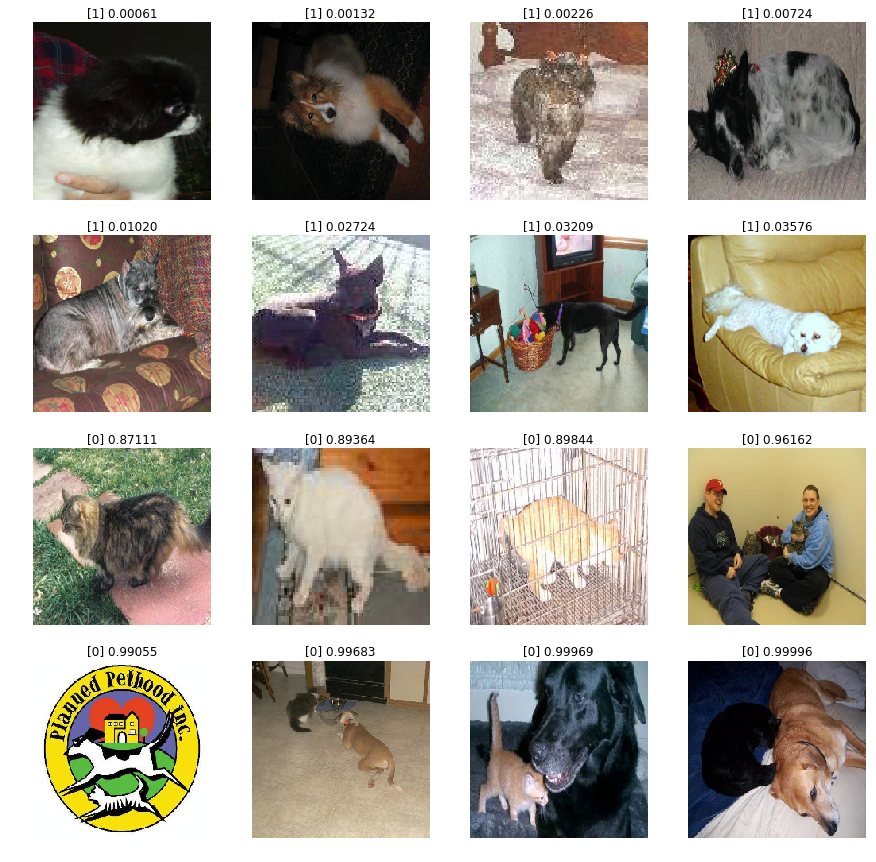

In [12]:
visualize_mismatch_probas(trainer, dloader=dset_loaders['valid'])

### Equívocos no conjunto de treino

predict: 399 ok
mistakes: 11 / 20000


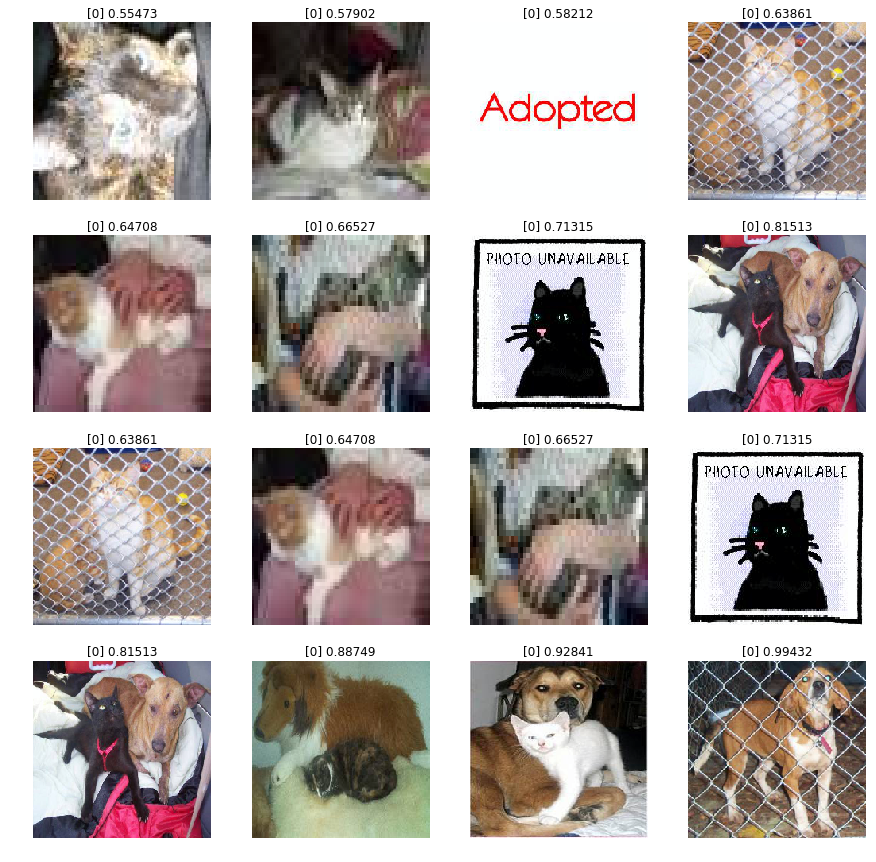

In [13]:
dloader = DataLoader(dsets['train'], batch_size=batch_size, shuffle=False)
visualize_mismatch_probas(trainer, dloader=dloader)

## Kaggle submission

In [14]:
def gen_kaggle_submission(data_loader=dset_loaders['test'], fn='kaggle_submission.csv'):
    from torch.nn.functional import softmax
    preds = trainer.predict(data_loader)
    probas = softmax(preds).data[:, 1].cpu().numpy()
    probas = np.around(probas, decimals=3)
    probas = np.clip(probas, 0.002, 0.998)
    with open(fn, 'w') as sub:
        print('id,label', file=sub)
        for i in range(probas.shape[0]):
            print('{},{:.3f}'.format(i+1, probas[i]), file=sub)

gen_kaggle_submission()

# cats_dogs_resnet34_01: no clip,         loss = 0.06886
# cats_dogs_resnet34_01: clip: 0.9998,    loss = 0.05960
# cats_dogs_resnet34_01: clip: 0.998,     loss = 0.05264  #86
# cats_dogs_resnet34_01: clip: 0.98,      loss = 0.05951


predict: 249 ok
